# 🤖 Trenowanie Modeli - Moodify

## 🎯 Cel
Wytrenowanie dwóch prostych modeli do rozpoznawania emocji:
- 📝 **Model Tekstowy** - scikit-learn (TF-IDF + klasyfikator)
- 📸 **Model Obrazowy** - TensorFlow/Keras (Transfer Learning)

---
# CZĘŚĆ 1: MODEL TEKSTOWY (scikit-learn)
---

## 1. Instalacja bibliotek

In [11]:
!pip install scikit-learn pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


## 2. Import bibliotek

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

print("Biblioteki załadowane!")
print(f"scikit-learn gotowy do pracy!")

Biblioteki załadowane!
scikit-learn gotowy do pracy!


## 3. Wczytanie danych tekstowych

In [13]:
train_text = pd.read_csv('processed_data/train_text.csv')
val_text = pd.read_csv('processed_data/val_text.csv')
test_text = pd.read_csv('processed_data/test_text.csv')

print("Dane wczytane!")
print(f"Train: {len(train_text)} przykładów")
print(f"Validation: {len(val_text)} przykładów")
print(f"Test: {len(test_text)} przykładów")

print("\nPrzykładowe dane:")
print(train_text.head())

Dane wczytane!
Train: 16000 przykładów
Validation: 2000 przykładów
Test: 2000 przykładów

Przykładowe dane:
                                                text    emotion
0                            i didnt feel humiliated     Smutek
1  i can go from feeling so hopeless to so damned...     Smutek
2   im grabbing a minute to post i feel greedy wrong      Złość
3  i am ever feeling nostalgic about the fireplac...  Szczęście
4                               i am feeling grouchy      Złość


## 4. TF-IDF Vectorization

**Co to TF-IDF?**
- **TF** (Term Frequency) = jak często słowo występuje w tekście
- **IDF** (Inverse Document Frequency) = jak unikalne jest słowo
- **Razem:** ważne słowa = częste w tym tekście + rzadkie globalnie

**Przykład:**
- "happy" w "I'm so happy!" → wysoki TF-IDF (ważne)
- "the" w każdym tekście → niski TF-IDF (nieważne)

**To jak zamiana tekstu na liczby!**

**Parametry vectorizera:**
- max_features=5000: Top 5000 najważniejszych słów
- min_df=2: Słowo musi wystąpić w min 2 dokumentach
- max_df=0.8: Ignoruj słowa w >80% dokumentów (stop words)
- ngram_range=(1,2): Pojedyncze słowa i pary słów

**Proces:**
1. FIT na train - uczy się słownika
2. TRANSFORM na val/test - używa tego samego słownika

In [14]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_text['text'])
y_train = train_text['emotion']

X_val = vectorizer.transform(val_text['text'])
y_val = val_text['emotion']

X_test = vectorizer.transform(test_text['text'])
y_test = test_text['emotion']

print("TF-IDF vectorization gotowa!")
print(f"\nKształt danych:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nSłownik ma {len(vectorizer.vocabulary_)} unikalnych słów")

TF-IDF vectorization gotowa!

Kształt danych:
X_train: (16000, 5000)
X_val: (2000, 5000)
X_test: (2000, 5000)

Słownik ma 5000 unikalnych słów


## 5. Trening modelu SVM

**Support Vector Machine (SVM):**
- Najpopularniejszy dla klasyfikacji tekstu
- Kernel='linear' dla TF-IDF (najlepsze wyniki)
- Znajduje optymalną granicę między klasami

In [15]:
print("Trenowanie modelu SVM...")

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

val_accuracy = svm.score(X_val, y_val)
print(f"\nValidation Accuracy: {val_accuracy:.2%}")

print("\nTrening zakończony!")

Trenowanie modelu SVM...

Validation Accuracy: 90.65%

Trening zakończony!

Validation Accuracy: 90.65%

Trening zakończony!


## 6. Ewaluacja na zbiorze testowym

In [16]:
y_pred = svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2%}")

print("\nClassification Report:\n")
report = classification_report(y_test, y_pred, output_dict=True)

for emotion, metrics in report.items():
    if emotion in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    print(f"{emotion}:")
    print(f"  Precision: {metrics['precision']:.2%}")
    print(f"  Recall:    {metrics['recall']:.2%}")
    print(f"  F1-Score:  {metrics['f1-score']:.2%}")
    print()

print(f"Overall Accuracy: {report['accuracy']:.2%}")

Test Accuracy: 90.25%

Classification Report:

Smutek:
  Precision: 92.17%
  Recall:    91.22%
  F1-Score:  91.70%

Strach:
  Precision: 85.38%
  Recall:    80.80%
  F1-Score:  83.03%

Szczęście:
  Precision: 91.83%
  Recall:    97.42%
  F1-Score:  94.55%

Zaskoczenie:
  Precision: 70.00%
  Recall:    53.03%
  F1-Score:  60.34%

Złość:
  Precision: 88.33%
  Recall:    82.55%
  F1-Score:  85.34%

Overall Accuracy: 90.25%


## 7. Confusion Matrix

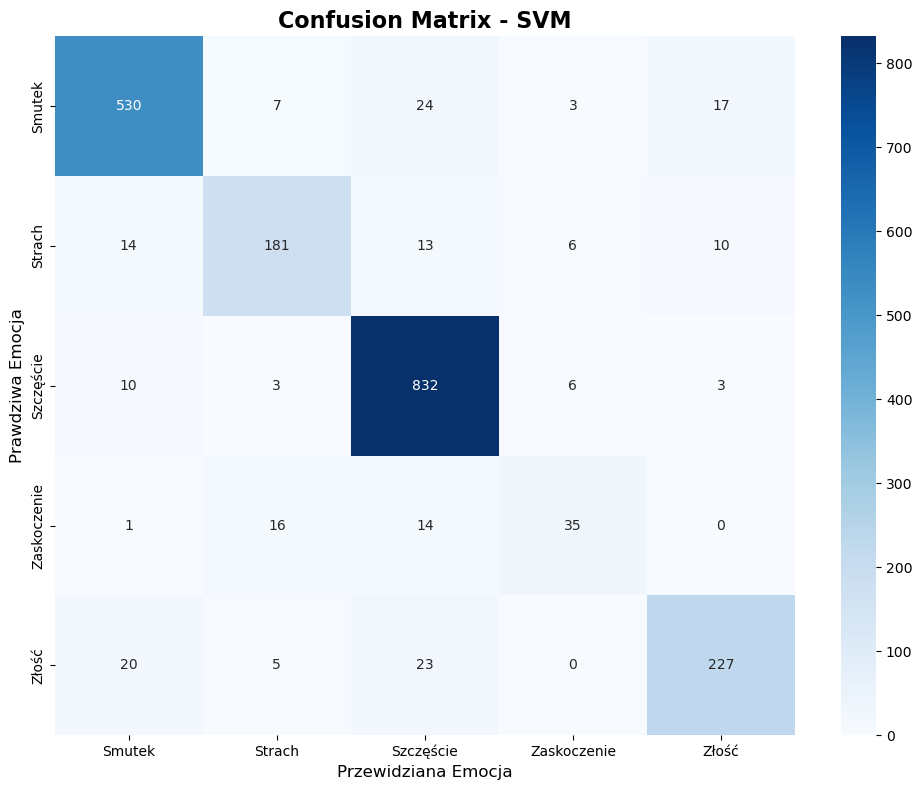

In [17]:
cm = confusion_matrix(y_test, y_pred)
emotions = sorted(train_text['emotion'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions)
plt.title('Confusion Matrix - SVM', fontsize=16, fontweight='bold')
plt.ylabel('Prawdziwa Emocja', fontsize=12)
plt.xlabel('Przewidziana Emocja', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Zapisanie modelu tekstowego

In [18]:
import os

model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

joblib.dump(svm, f'{model_dir}/svm_text_model.pkl')
joblib.dump(vectorizer, f'{model_dir}/tfidf_vectorizer.pkl')

print("Model i vectorizer zapisane:")
print(f"  - {model_dir}/svm_text_model.pkl")
print(f"  - {model_dir}/tfidf_vectorizer.pkl")

Model i vectorizer zapisane:
  - saved_models/svm_text_model.pkl
  - saved_models/tfidf_vectorizer.pkl


## 9. Test predykcji na nowych tekstach

In [19]:
def predict_emotion_text(text):
    """Przewiduje emocję dla nowego tekstu"""
    text_vectorized = vectorizer.transform([text])
    prediction = svm.predict(text_vectorized)
    return prediction[0]

test_texts = [
    "I am so happy today!",
    "This is terrible, I hate it",
    "I'm feeling really sad and lonely",
    "Wow, I didn't expect that!",
    "I'm scared of what might happen"
]

print("Testowanie modelu na nowych tekstach:\n")
for text in test_texts:
    emotion = predict_emotion_text(text)
    print(f"Tekst: \"{text}\"")
    print(f"Emocja: {emotion}\n")

Testowanie modelu na nowych tekstach:

Tekst: "I am so happy today!"
Emocja: Szczęście

Tekst: "This is terrible, I hate it"
Emocja: Smutek

Tekst: "I'm feeling really sad and lonely"
Emocja: Smutek

Tekst: "Wow, I didn't expect that!"
Emocja: Szczęście

Tekst: "I'm scared of what might happen"
Emocja: Strach



---
# CZĘŚĆ 2: MODEL OBRAZOWY (TensorFlow/Keras)
---

## 11. Instalacja TensorFlow

In [20]:
!pip install tensorflow pillow

Defaulting to user installation because normal site-packages is not writeable


## 12. Import bibliotek dla obrazów

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

print("TensorFlow załadowany!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow załadowany!
TensorFlow version: 2.19.0
GPU available: False


## 13. Wczytanie danych obrazowych

In [22]:
train_img = pd.read_csv('processed_data/train_images.csv')
val_img = pd.read_csv('processed_data/val_images.csv')
test_img = pd.read_csv('processed_data/test_images.csv')

print("Dane obrazowe wczytane!")
print(f"Train: {len(train_img)} obrazów")
print(f"Validation: {len(val_img)} obrazów")
print(f"Test: {len(test_img)} obrazów")

emotions_list = sorted(train_img['emotion'].unique())
emotion_to_id = {emotion: idx for idx, emotion in enumerate(emotions_list)}
id_to_emotion = {idx: emotion for emotion, idx in emotion_to_id.items()}

print(f"\nEmocje: {emotions_list}")
print(f"Mapowanie: {emotion_to_id}")

Dane obrazowe wczytane!
Train: 14106 obrazów
Validation: 3023 obrazów
Test: 3023 obrazów

Emocje: ['Smutek', 'Strach', 'Szczęście', 'Zaskoczenie', 'Złość']
Mapowanie: {'Smutek': 0, 'Strach': 1, 'Szczęście': 2, 'Zaskoczenie': 3, 'Złość': 4}


## 13a. Wczytanie ścieżki bazowej

CSV zawiera ścieżki **względne**. Musimy wczytać absolutną ścieżkę do bazy danych.

In [23]:
import json
import os

with open('processed_data/data_paths.json', 'r', encoding='utf-8') as f:
    data_paths = json.load(f)

BASE_PATH = data_paths['affectnet_base_path']
print(f"Ścieżka bazowa wczytana:")
print(f"   {BASE_PATH}")
print(f"\nPrzykładowa pełna ścieżka:")
sample_relative = train_img['path'].iloc[0]
sample_full = os.path.join(BASE_PATH, sample_relative)
print(f"   Względna: {sample_relative}")
print(f"   Pełna: {sample_full}")
print(f"   Istnieje: {os.path.exists(sample_full)}")

Ścieżka bazowa wczytana:
   C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1

Przykładowa pełna ścieżka:
   Względna: archive (3)\Train\fear\image0037941.jpg
   Pełna: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Train\fear\image0037941.jpg
   Istnieje: True


## 14. Generator danych

In [24]:
IMG_SIZE = 224
BATCH_SIZE = 32

def create_dataset(df, emotion_to_id, base_path):
    """Tworzy TensorFlow dataset z DataFrame"""
    
    def load_image(path, label):
        full_path = tf.strings.join([base_path, os.sep, path])
        img = tf.io.read_file(full_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = img / 255.0
        return img, label
    
    labels = df['emotion'].map(emotion_to_id).values
    paths = df['path'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_ds = create_dataset(train_img, emotion_to_id, BASE_PATH)
val_ds = create_dataset(val_img, emotion_to_id, BASE_PATH)
test_ds = create_dataset(test_img, emotion_to_id, BASE_PATH)

print("Datasety TensorFlow gotowe!")

Datasety TensorFlow gotowe!


## 15. Transfer Learning z MobileNetV2

**MobileNetV2:**
- Lekki CNN (działa nawet na telefonie!)
- Wytrenowany na ImageNet (1.4M obrazów, 1000 klas)
- Rozumie podstawowe cechy: krawędzie, tekstury, kształty

**Nasza architektura:**
- MobileNetV2 (zamrożony) - ekstrakcja features
- GlobalAveragePooling - agreguje features
- Dense(128, relu) - warstwa ukryta
- Dropout(0.5) - zapobiega overfittingowi
- Dense(5, softmax) - klasyfikacja na 5 emocji

**To jest Transfer Learning!**

In [25]:
from tensorflow.keras import Sequential

print("Budowanie modelu z Transfer Learningiem (MobileNetV2)...")

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

model_image = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

print("\nArchitektura modelu:")
model_image.summary()

trainable = sum([tf.size(w).numpy() for w in model_image.trainable_weights])
print(f"\nParametry:")
print(f"- Trenowalne: {trainable:,}")
print(f"- Zamrożone (MobileNetV2): {model_image.count_params() - trainable:,}")

Budowanie modelu z Transfer Learningiem (MobileNetV2)...

Architektura modelu:

Architektura modelu:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Parametry:
- Trenowalne: 164,613
- Zamrożone (MobileNetV2): 2,257,984


## 16. Kompilacja modelu

**Ustawienia:**
- **Optimizer:** Adam (standardowy, adaptacyjny learning rate)
- **Loss:** sparse_categorical_crossentropy (dla klas 0,1,2,3,4)
- **Metrics:** accuracy (% poprawnych predykcji)

In [26]:
from tensorflow.keras.optimizers import Adam

model_image.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model skompilowany!")

Model skompilowany!


## 17. TRENING MODELU OBRAZOWEGO 🚀

**Czas:** ~30-40 minut (bez GPU) lub ~10-15 minut (z GPU)

**Epoki:** 20 epok (z early stopping)
- Transfer Learning = model już rozumie obrazy
- My tylko uczymy go 5 emocji
- EarlyStopping zatrzyma trening jeśli brak poprawy

**Callbacks:**
- ModelCheckpoint - zapisuje najlepszy model
- EarlyStopping - zatrzyma się jeśli nie ma poprawy

In [ ]:
print("Rozpoczynam trening modelu obrazowego...\n")

checkpoint = keras.callbacks.ModelCheckpoint(
    'saved_models/image_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

history = model_image.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

print("\nTrening zakończony!")

Rozpoczynam trening modelu obrazowego...

Epoch 1/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.3127 - loss: 1.6449
Epoch 1: val_accuracy improved from -inf to 0.47833, saving model to saved_models/image_model_best.h5

Epoch 1: val_accuracy improved from -inf to 0.47833, saving model to saved_models/image_model_best.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 197s 438ms/step - accuracy: 0.3129 - loss: 1.6445 - val_accuracy: 0.4783 - val_loss: 1.2560
Epoch 2/5
Epoch 2/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.4586 - loss: 1.2842
Epoch 2: val_accuracy improved from 0.47833 to 0.51538, saving model to saved_models/image_model_best.h5

Epoch 2: val_accuracy improved from 0.47833 to 0.51538, saving model to saved_models/image_model_best.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 191s 434ms/step - accuracy: 0.4586 - loss: 1.2841 - val_accuracy: 0.5154 - val_loss: 1.1634
Epoch 3/5
Epoch 3/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.4864 - loss: 1.2002
Epoch 3: val_accuracy improved from 0.51538 to 0.53291, saving model to saved_models/image_model_best.h5

Epoch 3: val_accuracy improved from 0.51538 to 0.53291, saving model to saved_models/image_model_best.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 191s 434ms/step - accuracy: 0.4864 - loss: 1.2002 - val_accuracy: 0.5329 - val_loss: 1.1215
Epoch 4/5
Epoch 4/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.5065 - loss: 1.1593
Epoch 4: val_accuracy improved from 0.53291 to 0.53953, saving model to saved_models/image_model_best.h5

Epoch 4: val_accuracy improved from 0.53291 to 0.53953, saving model to saved_models/image_model_best.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 191s 433ms/step - accuracy: 0.5065 - loss: 1.1593 - val_accuracy: 0.5395 - val_loss: 1.0940
Epoch 5/5
Epoch 5/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5271 - loss: 1.1128
Epoch 5: val_accuracy improved from 0.53953 to 0.55475, saving model to saved_models/image_model_best.h5

Epoch 5: val_accuracy improved from 0.53953 to 0.55475, saving model to saved_models/image_model_best.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 192s 434ms/step - accuracy: 0.5271 - loss: 1.1128 - val_accuracy: 0.5547 - val_loss: 1.0727

Trening zakończony!

Trening zakończony!


## 18. Wykresy treningu

**Interpretacja:**
- Accuracy rośnie → model się uczy!
- Loss maleje → model robi coraz mniej błędów
- Train ≈ Validation → brak overfittingu ✅
- Train >> Validation → overfitting ⚠️

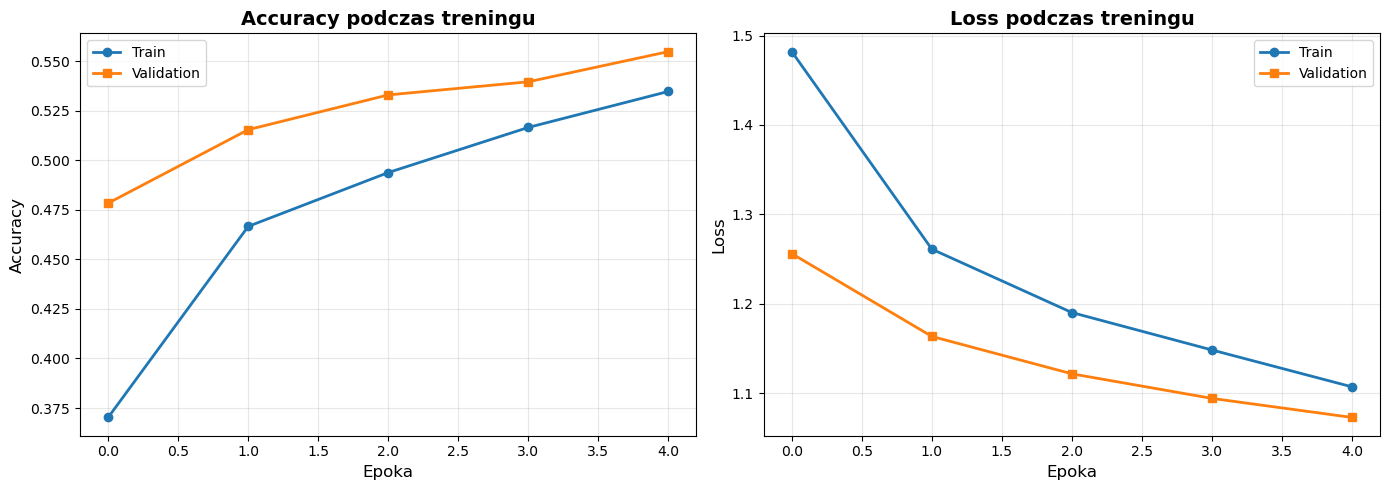

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], marker='o', label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], marker='s', label='Validation', linewidth=2)
ax1.set_title('Accuracy podczas treningu', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoka', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], marker='o', label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], marker='s', label='Validation', linewidth=2)
ax2.set_title('Loss podczas treningu', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoka', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 19. Ewaluacja na zbiorze testowym

In [29]:
model_image = keras.models.load_model('saved_models/image_model_best.h5')

test_loss, test_acc = model_image.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 356ms/step - accuracy: 0.5647 - loss: 1.0673
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 356ms/step - accuracy: 0.5647 - loss: 1.0673

Test Accuracy: 56.10%
Test Loss: 1.0614

Test Accuracy: 56.10%
Test Loss: 1.0614


## 20. Confusion Matrix dla obrazów

Generowanie predykcji...


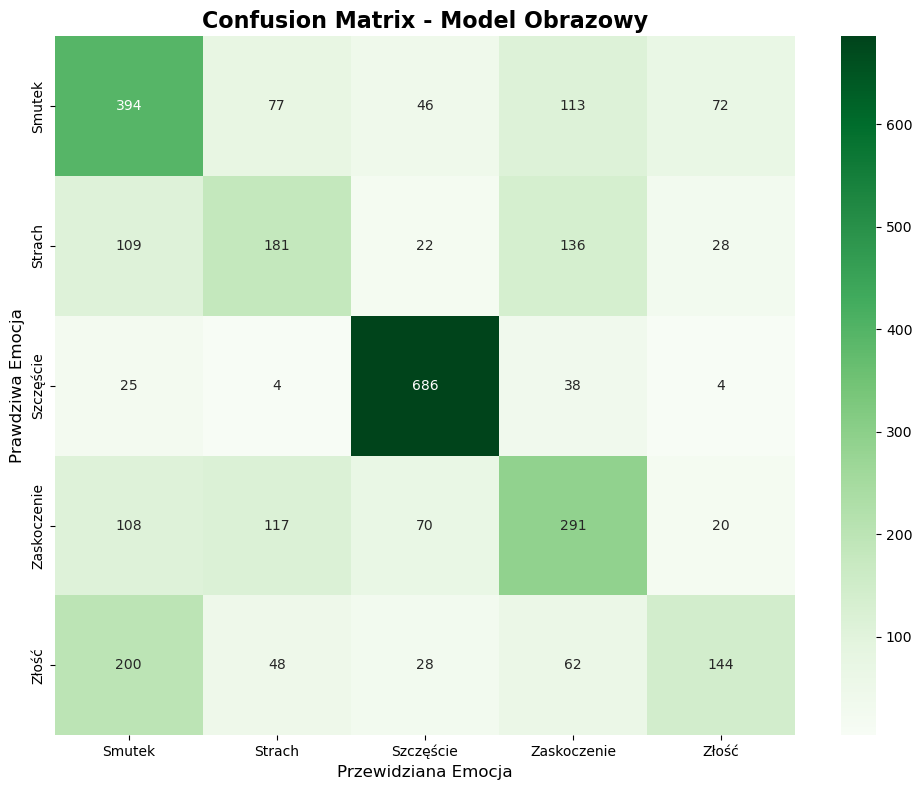


Classification Report:

Smutek:
  Precision: 47.13%
  Recall:    56.13%
  F1-Score:  51.24%

Strach:
  Precision: 42.39%
  Recall:    38.03%
  F1-Score:  40.09%

Szczęście:
  Precision: 80.52%
  Recall:    90.62%
  F1-Score:  85.27%

Zaskoczenie:
  Precision: 45.47%
  Recall:    48.02%
  F1-Score:  46.71%

Złość:
  Precision: 53.73%
  Recall:    29.88%
  F1-Score:  38.40%

Overall Accuracy: 56.10%


In [30]:
y_pred = []
y_true = []

print("Generowanie predykcji...")
for images, labels in test_ds:
    preds = model_image.predict(images, verbose=0)
    y_pred.extend(preds.argmax(axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotions_list,
            yticklabels=emotions_list)
plt.title('Confusion Matrix - Model Obrazowy', fontsize=16, fontweight='bold')
plt.ylabel('Prawdziwa Emocja', fontsize=12)
plt.xlabel('Przewidziana Emocja', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, target_names=emotions_list, output_dict=True)

for emotion in emotions_list:
    metrics = report[emotion]
    print(f"{emotion}:")
    print(f"  Precision: {metrics['precision']:.2%}")
    print(f"  Recall:    {metrics['recall']:.2%}")
    print(f"  F1-Score:  {metrics['f1-score']:.2%}")
    print()

print(f"Overall Accuracy: {report['accuracy']:.2%}")

## 21. Zapisanie finalnego modelu

In [31]:
model_image.save('saved_models/image_model_final.h5')

import json
with open('saved_models/image_emotion_map.json', 'w') as f:
    json.dump(id_to_emotion, f)

print("Model obrazowy zapisany!")
print("   - saved_models/image_model_final.h5")
print("   - saved_models/image_emotion_map.json")

Model obrazowy zapisany!
   - saved_models/image_model_final.h5
   - saved_models/image_emotion_map.json
